## Optimizing C# ##

I've been creating a financial derivatives pricing model over the past few years that's highly accurate. It started off as a model that needed to be used very selectively, because it took around 10 seconds to run it on all S&P 500 index options, and with ~20 parameters that needed to be calibrated to fit market prices, it would take sometimes up to an hour to calibrate. But as time passed, I learned new coding and mathematical optimizations that have now sped it up to about 5 milliseconds. Much of this was accomplished due to refining a constrained linear programming procedure that needed to run 1000s of times from around 1 millisecond to 10s of nanoseconds. I won't go into that one, but I did want to share some of the several other lessons I learned about high performance coding in C#. 

In this repo, I present a set of microbenchmarks run with BenchmarkDotNet that I found interesting enough to want to share. As you go through this, you'll notice that some of my math doesn't add up. This is often because I talk in terms of improvements on serial operations, and my acutal code features several parallel operations. Also because I did a lot of mental math while writing this, and I'm plenty fallible.

Of note, I ran everything on a Ryzen 5900X and Windows 10, and I used .NET 6.0 as the target framework. 

## Things I Thought Mattered, But Didn't ##

### Virtual Function Overhead ###

Coming from a more formal C++ background, I knew that V tables are one source of slowness that was obvious and easily fixable with the Curiously Recurring Template Pattern. I didn't know (and still don't know) if there's a static polymorphism hack in C# [1], but luckily I never needed to. In the `InterfaceCost` benchmark, I tested the overhead, and it amounted to nearly nothing in an absolute sense. 

In [ ]:
public interface IShift
{
    [MethodImpl(MethodImplOptions.NoInlining)]
    uint NoInlineShift(uint x);

    uint Shift(uint x);
}

public class ShiftClass : IShift
{
    [MethodImpl(MethodImplOptions.NoInlining)]
    public uint NoInlineShift(uint x)
    {
        return x << 1;
    }

    public uint Shift(uint x)
    {
        return x << 1;
    }
}

Testing all four method calls, I got the following result:

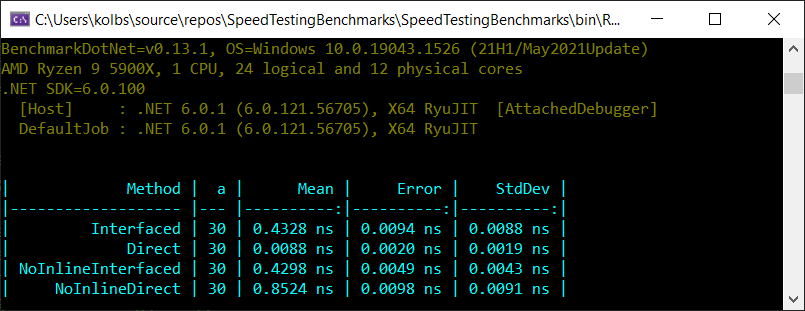

Interestingly enough, it seems like all of the value of a direct method call lies in the fact that the compiler can inline more easily. That's not nothing. If you have very short virtual methods that get called millions of times, then you can start to shave off milliseconds, but for my program, I called virtual methods a few thousand times, and it seems at best I would be looking at a 500ns improvement to getting rid of them. And that's not enough to sacrifice the advantages of interfaces, IMO. I'm not gonna lie, I cannot entirely explain the numbers I see here. The `Direct` call being significantly faster than a single clock cycle is concerning, though not impossible. But the main takeaway I think is how little overhead interfaces offer, even if calling directly is basically free.

### Avoiding The Mod Operator ###

Another thing that seems common in CS lore is avoiding the mod operator. Since I use SIMD (we'll get to that later), I do a lot of `x % 4` and `x % 8` calls, but the evils of modulo weren't apparent. I figured `x & 7` would handily beat `x % 8`. I was wrong. On `uint`s, they're exactly the same, and on `int`s, the mod operator performs at most 4x worse. But 4x slower in this case again means very little. The baseline is about 0.2ns. I ended up using the faster method because there's no cost to it, but this 0.6ns save was not worth the effort. 

### CUDA ###

Between the cost of data transfer and CUDA being very application specific and Nvidia throttling my RTX 3080 on doubles, CUDA never panned out. I was able to match performance on a few things, but never improve. After talking with a CS professor, he told me "GPUs almost never offer the improvements people expect unless you want to measure in energy expenditure." I will remember that.

## Things That Mattered A Lot ##

### "Hashing" Instead of Binary Search ###

This is a little harder to explain, but I have a key-value pair (KVP) list that is ordered by keys, which are `double`s. What's special about this list is that I frequently need to lookup the KVP using the closest key to the number I'm looking up. That is, if my key list is `list=[1,2,3,4,5]`, I want to find `index=1` when I lookup `2.1`. So I cannot just use a `Dictionary<>`, since most of the numbers I'm looking up wouldn't actually be keys. 

If my keys were evenly spaced, this would be easy. Using the `list` above `(int)(v+0.5)` would get me the right answer if I restrict lookup numbers to $x\in[1,5]$. Unfortunately, my list covers a very large range of values, and it needs to be concentrated around a mean (not unlike the Gaussian distribution). In general, what I would want is a function where $f(x)=v$ and $Round(f^{-1}(v))=i$ are known and `i` can be the index of our KVP and `v` the key. Then if I wanted to look up a number `x`, then `(int)(f^{-1}(x)+0.5)` would be the location of the KVP. This takes the lookup from being an O(log(n)) binary search to an O(1) hash-like lookup. 

I did indeed find a good function for this purpose. It's in the `Grid` class inside the `ListLookupTest.cs` document. Following this instead of a binary search reduced each lookup from 26ns to 8ns. And since I needed to do about 500,000 of these for every model call, this saved nearly 10 milliseconds. One interesting thing about these functions was that they included a call to `Math.Log`.

Much like the mod operator, log is also notoriously bad. For my use case, accuracy isn't very important, so attempting to rewrite `Math.Log()` seemed promising. A quick google landed on an analytic formula I adapted from someone's C++ code. I put that in `Grid.fast_log()`. I also created a cache-based system that satisfied my accuracy/bounds requirements. That's summarized below.

In [8]:
const int LOG_CACHE_SIZE = 10000;
double[] logcache = new double[LOG_CACHE_SIZE];

// this is done at initialization and stored
for (int ii = 0; ii < LOG_CACHE_SIZE; ++ii)
{
    // divide by 5000
    logcache[ii] = Math.Log(0.01 * (ii + 1) + 1.0, 1.016); // i.e. Math.Log(50 * ii / 1000 + 1.0, 1.016)
}

double MyLog(double x)
{
    var dn = (int)(x * 5000);
    dn = dn > LOG_CACHE_SIZE - 1 ? LOG_CACHE_SIZE - 1 : dn;

    return logcache[dn];
}

To my surprise, the cached log crushed both `Grid.fast_log()` and `Math.Log()`. 

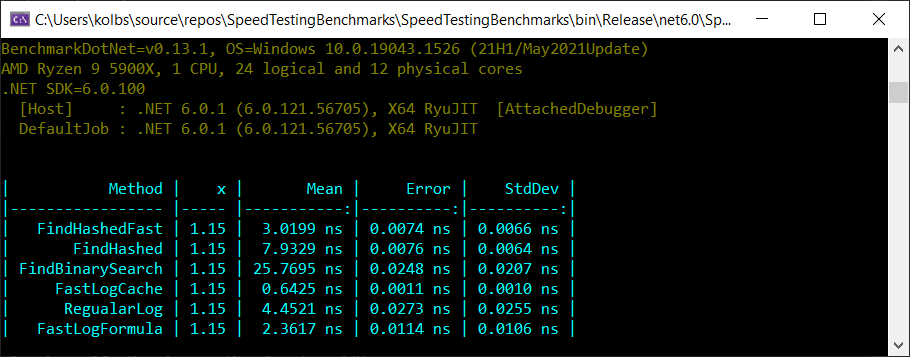

This set of benchmarks tested both the search algorithm as well as the logs. Notice we saved an additional 4ns per call by switching to a cached version of the logarithm, bringing total saving to nearly 23ns on 500,000 calls.


### SIMD ###

One really nice thing that C++ compilers do is go ahead and use SIMD instructions whenever it's appropriate. C# compilers are not so kind. But Microsoft does supply an `Avx` and `Avx2` class that you can use to call AVX2 instructions manually. I had been using a mix of Accord and MathNet prior to experimenting with SIMD, so I set up a benchmark of doing a dot product on two 500 element arrays. The following code blows both of them out of the water.

In [4]:
using System.Runtime.Intrinsics;
using System.Runtime.Intrinsics.X86;

const uint MAX_MINUS_FOUR = 0b_1111_1111_1111_1111_1111_1111_1111_1100;

public static unsafe double DotAvx(double* x, double* y, uint n)
{
    var vresult = Vector256<double>.Zero;

    for (int i = 0; i < (n - 2); i += 4)
    {
        var xx = Avx.LoadVector256(x + i);
        var yy = Avx.LoadVector256(y + i);
        var rr = Avx.Multiply(xx, yy);
        vresult = Avx.Add(rr, vresult);
    }

    vresult = Avx.HorizontalAdd(vresult, vresult);
    vresult = Avx.HorizontalAdd(vresult, vresult);

    var r = vresult.GetElement(0);
            
    // gets the closest power of 4 below n
    var nn = n & MAX_MINUS_FOUR; // ((n >> 2) << 2);

    // clean up the residual
    for (uint i = nn; i < n; i++)
        r += x[i] * y[i];

    return r;
}

The results:

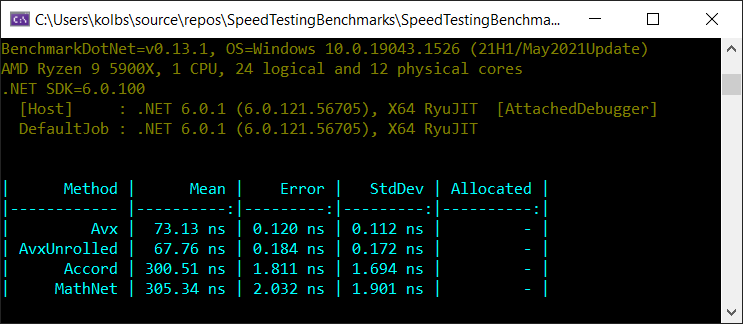

The Avx-accelerated version does a 500 element dot product about 4x faster, which shouldn't be at all surprising. I also created an unrolled version of the Avx calculation that comes in at 10% faster yet. I need to call a function like this about 20,000 times in my model, meaning Avx saved five milliseconds just on this one task. 

### Reducing Allocations ###

You cannot even begin to talk about optimizing C# without acknowledging memory management. I forget which book I read this in, but your goal should be to never have anything but Gen 0 garbage collections. That is, if you create an object, never delete it, or have Gen 0 delete it when it goes out of local scope. My research made me want to modify this statement for arrays: never delete an array allocated on the heap, and use `stackalloc` for local objects. 

The `new T[]` operator I'm almost willing to call a bug at this point. The only place you should ever call it is inside an `ObjectPool`. I set up tests for `new` heap allocation, object pool allocation and `stackalloc`. I also varied the sizes of the array being allocated using 20, 500 and 10,000 sized double arrays.

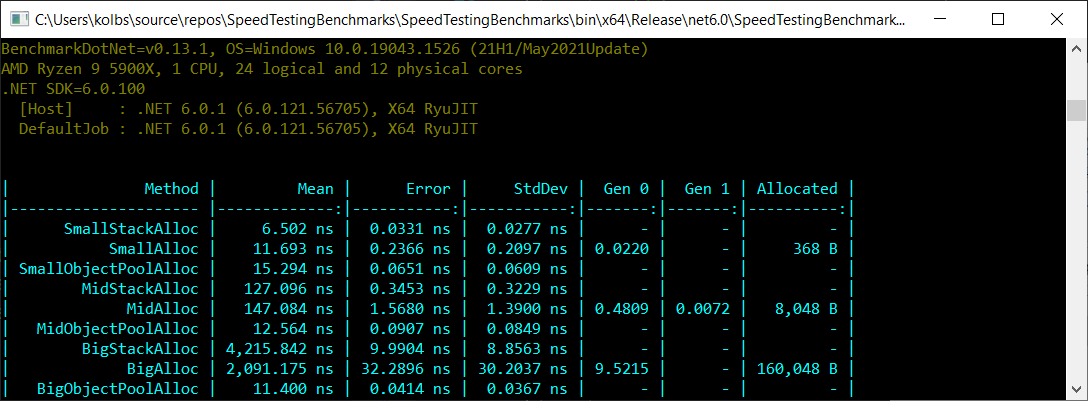

I was a little shocked at how much `stackalloc` degraded even on a 10,000 sized array, which is still well-below the stack's default size of 1MB. But for small arrays, its benefits are undeniable. I didn't quantify how much making these changes improved my code, but it's signifiant. I was originally very impressed by `stackalloc`, but testing made me realize it needs to come with a disclaimer. You can really shoot yourself in the foot if you accidentally start using it on even slightly large arrays.

### Reducing Allocations Edited and Corrected ###

The above analysis is misleading if not outright wrong. `Alloc` and `StackAlloc` are comperable, but `ObjectPool` ones are not. This is because two things happen when you initialize a array in C#, a section of memory is reserved and all its values are zeroed out! The `ObjectPool` code was not zeroing out the arrays, and it truns out that the zeroing process is orders of magnetide more time-consuming than allocation for the large array.

This is where we find maybe not a bug, but certainly an open issue in the dotnet repo. `stackalloc` uses 128 bit SIMD registers to zero out its array, whereas `new` uses 256. Hense the perplexing and roughly 2x slowdown when using `stackalloc` on larger arrays.

You can get around this by adding the `SkipLocalsInit` flag to any function calling `stackalloc`. This will suppress the zeroing part of initializing an array. Then you need to zero it out manually. That can be done by calling `Unsafe.InitBlock`, or I included my own implementation of applying zeros with AVX instructions. This gives the results below for comparing the time to initialize various arrays to zero.

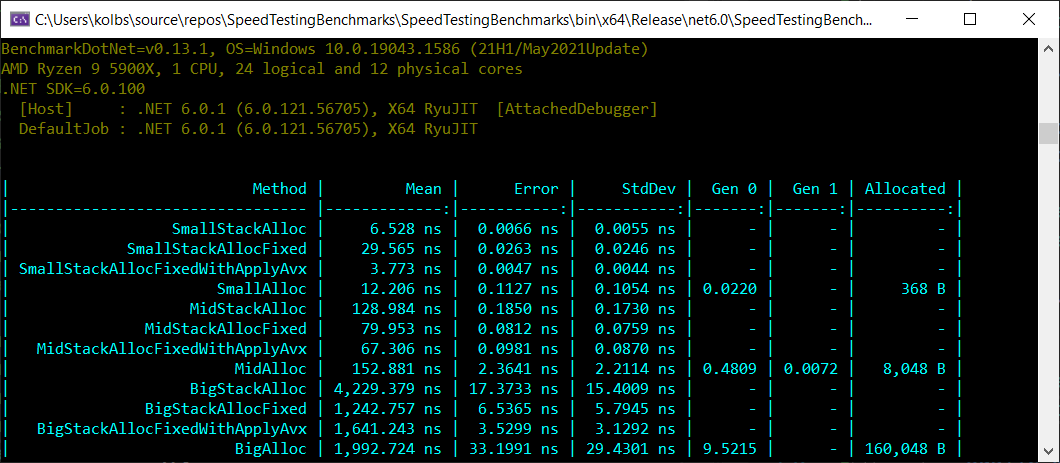

These results are indicative of a common problem in high performance C#: someone somewhere else has made something faster for most things you want to do, but not so much faster that it's worth it to marshall data to do an external call or even to make an addicional IAT lookup. In this case, `Unsafe.InitBlock` is probably better written than my Avx implementation. We see as N gets larger, `Unsafe.InitBlock` starts beating mine. But the cost of calling it is a IAT lookup, which is significant for small N. 

If instead you are looking to initialize your array to arbitraty values because you plan on assigning before reading, then here is the proper comparison between the three techniques.

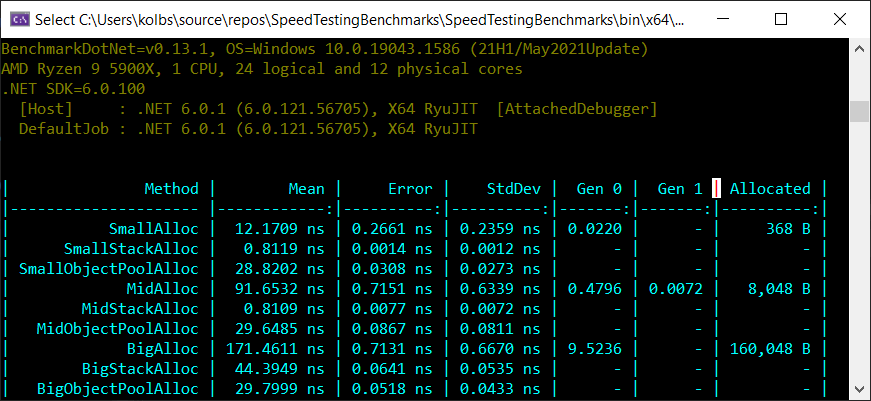

Of note: you can suppress zeroing of heap allocated arrays by calling them with `GC.AllocateUninitializedArray<double>`, not that there's ever any need to.

One thing I find fascinating about these reuslts is the speed-up involved in simply thinking about what you really want to do with an array, and knowing the tools availiable to do exactly that. I was pretty deep into this optimization journey, and it didn't even occur to me that I could allocate arrays without zeroing them. If you simply don't need your array zeroed and you know you can create an uninitialized array, that cuts down an allocation on a `N=10000` array by 40x. This is interesting because most people don't know this is an option, and I think it's unfortunate that it's so easy to do it the slow way, and so difficult to figure out how to do it the right way. And it's probably reasons like this that C# gets a reputation for being slow. 

## Things That Mattered A Little ##

### Going Deeper into SIMD ###

Basic SIMD operations like filling/clearing arrays or linear algebra are clear slam-dunk uses of the ```Intrinsics``` library in C#. Unless you don't care about performance, it's very easy to tap these resources at little cost to development time or reliability. But what about everything else?

That question isn't so easy to answer for everyone. Once I decided to go down this route, I learned that there were very few resources to lean on, so development time became a serious consideration, and to make matters worse, it's even more difficult than normal to estimate dev time. Regardless of those difficulties, I pressed on to find some more complicated speedups opportunities in my model. One glaring one is my use of Math.Net's error function ("Erf") repeatedly within a loop.

The approximation of Erf depends on an exponential function. Unfortunately, there is no AVX2 intrinsic for the exponential. In fact there are very few intrinisics for common mathematical operations (one exception is the square root). So, in order to build `Erf(x)`, I first needed to build `exp(x)`.

I looked around and found a C implementation of an AVX-assisted `exp(float)`, and I adapted it to take a `double` as an argument instead. This wasn't a light task. Between figuring out which algorithm to use, coding them up, testing them, inventing a new algorithm, it was around 15 hours of work. Not ideal compared to calling `Math.Exp(x)` in a second. The results were just great, however. As far as I can tell, I used virtually the same algorithm that `Math.Exp(double)` calls, so error is negligible. 

With Erf, I was a little bit more flexible to accept error than MathNet promised. Aside from that, MathNet's algorithm had considerable branching in it, which meant I couldn't just adapt their code to SIMD. Wikipedia led me to a fast approximation with maximum 1.5e-7 error and no branching, so I implemented that.  

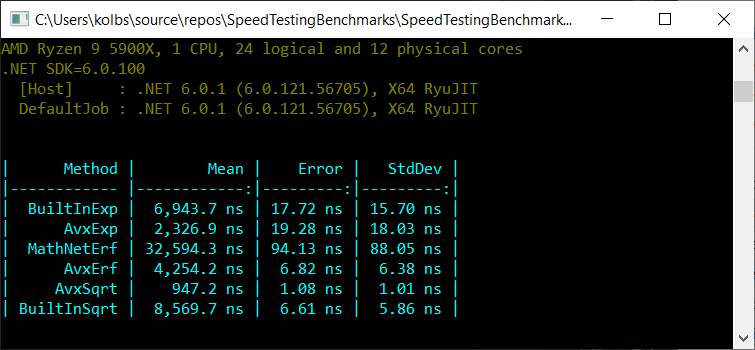

The results were solid in my opinion. I even tested the `Avx.Sqrt()` function in case I could find a good use of it in a different approximation. My model calls Erf in chunks of 2048 about 500 times. That's a 15ms improvement. Worth it? Probably. Maybe not. If speedup alone were my onlyconsideration, I think it's a clear win, but now I'm dependent on my own implementation of `exp(x)` instead of an expert's, and I'm not sure this will be a good thing in the long run. But if I ever need to call square root repeatedly, I know that will be an easy optimization.


### Inlining ###

This whole experience made me realize I've been using the `[MethodImpl(MethodImplOptions.AggressiveInlining)]` attribute all wrong: my default has been to rarely use it, but I should be to adding it to every method possible. 

I've never worked on a particularly large code base. My current math/modeling tools library compiles to a 185KB dll. There is no excuse for me to be minimizing my dll size at the expense of performance [2]. And there are performance benefits in testing. I never tested them in my production because I just started littering them everywhere. 

Results from inlining vs not in testing:

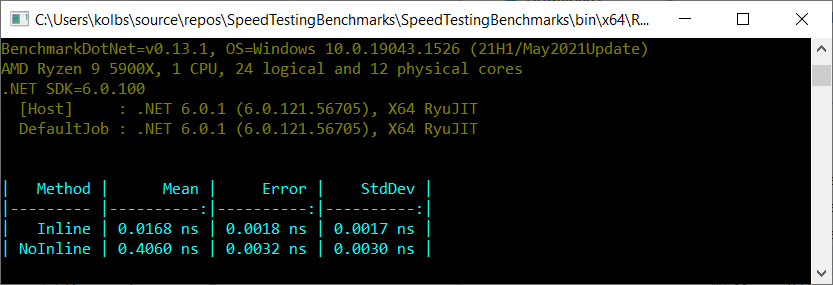

There have been a few results so far in other tests where I got a strange result only to add an `AggressiveInliining` attribute and see it go away.

### Unrolling ###

I always thought loop unrolling was kind of a myth, but it really does help a little, as you saw with my dot product AVX testing. 

## Conclusions ##

C# can be really fast if you put some effort into it. I'm not going to get into a language war, but a 500 element dot product in 67ns is really fast for any language. Like, suspiciously fast where I kinda doubt the absolute value of the numbers being output by Benchmark.net. My back of the envelope approximation is that a 500x500 matrix multiplication is 250000 of these dot products, which would bring total time to 16.75ms which is [very competitive with C++'s Eigen running on 3 year old hardware](https://medium.com/datathings/benchmarking-blas-libraries-b57fb1c6dc7). I think the downside is that C# really stops looking like C# when you do some of these optimizations. When I think of why I use C#, it's for a great package manager (which I rarely used becuase they were too slow), memory safety (which I had to eliminate), and a good garbage collector (which I try to suppress all use of). It makes you wonder if all this struggle to make C# go low is really as useful as just writing all of this in C instead. 

For me, the answer is 'yes' for a relatively petty reason: I love NodaTime too much, and I build around it. 

Another thing to consider is that I don't use AVX-512 in any of my SIMD speedups because my AMD processor doesn't support it, but Agner Fog seems to be a strong advocate for its usefulness, and Microsoft hasn't created a class wrapping any of them. So, food for thought there. 

## Notes ##

[1] My friend Scott Stephens noted that "if you use generic structs (as opposed to generic classes) in C# all of the static polymorphism tricks from C++ work."

[2] Scott also noted that "storage space on disk is not the only reason not to inline. The bigger your code is the harder it is to keep all the important parts in cache. If an inline pushes a hot section of your code out of the cache it can be very bad for performance."